# Import Dependencies


In [1]:

import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import  gym
#import gym
#from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score

# Mount Google Drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading


In [4]:
# Load data and prepare for modeling
file_path = '/content/drive/My Drive/blackjack_simulator.csv'
data = pd.read_csv(file_path, sep=',', nrows=100000)

# Action Prediction and Visualization


In [5]:
def predict_action(dealer_card, player_total, player_has_ace, model):
    """Predicts the best action ('Hit' or 'Stand') based on the model and plots the results."""
    input_features = pd.DataFrame({
        'dealer_card': [dealer_card],
        'player_total': [player_total],
        'player_ace': [1 if player_has_ace else 0]
    })
    action_prob = model.predict_proba(input_features)[0]
    actions = ['Hit', 'Stand']
    action = actions[model.predict(input_features)[0]]

    # Output the recommended action
    print(f"Recommended action: {action}")
    print(f"Probability of 'Hit': {action_prob[0]:.2f}")
    print(f"Probability of 'Stand': {action_prob[1]:.2f}")

    # Plotting the probabilities as a bar chart
    plt.figure(figsize=(8, 4))
    sns.barplot(x=actions, y=action_prob, color='mediumturquoise')  # Specify a single color or different colors for each bar
    plt.title('Action Probabilities')
    plt.ylabel('Probability')
    plt.show()

    # Pie chart visualization of probabilities
    plt.figure(figsize=(6, 6))
    plt.pie(action_prob, labels=actions, autopct='%1.1f%%', startangle=90, colors=['tomato', 'mediumseagreen'])
    plt.title('Action Distribution')
    plt.show()


# Data Preprocessing

In [6]:
# Load and prepare the dataset
data['initial_hand'] = data['initial_hand'].apply(eval)
data['dealer_final'] = data['dealer_final'].apply(eval)
data['player_final'] = data['player_final'].apply(eval)
data['actions_taken'] = data['actions_taken'].apply(eval)
data = data.explode('player_final')
data['actions_taken'] = data['actions_taken'].apply(lambda x: [item for sublist in x for item in (sublist if isinstance(sublist, list) else [sublist])])
data = data.explode('actions_taken')

In [7]:
# Filter for 'H' and 'S' actions
data = data[data['actions_taken'].isin(['H', 'S'])]
data['action_binary'] = data['actions_taken'].apply(lambda x: 1 if x == 'S' else 0)

# Prepare features and target variable
features = pd.DataFrame({
    'dealer_card': data['dealer_up'],
    'player_total': data['player_final'].apply(lambda hand: sum(hand) if isinstance(hand, list) else hand),
    'player_ace': data['player_final'].apply(lambda hand: 1 if 11 in hand else 0)
})
target = data['action_binary']

<ipython-input-7-2370c3e8d0fc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['action_binary'] = data['actions_taken'].apply(lambda x: 1 if x == 'S' else 0)


# Model Training


In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
acclist = []
perlist = []


KNNlist = [x for x in range(1,26,2)]

for k in KNNlist:
# Initialize and fit the K-Nearest Neighbors (KNN) classifier
    model = KNeighborsClassifier(n_neighbors=k)  # You can adjust the number of neighbors (k) as needed
    model.fit(X_train, y_train)
    # Predictions and evaluation
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    percision = precision_score(y_test,y_pred,average='weighted')
    acclist.append(accuracy)
    perlist.append(percision)

totalscore = pd.DataFrame({'Accuracy' : acclist , 'Percision' : perlist} , index = KNNlist)
totalscore

,Accuracy,Percision
1,0.688798,0.695273
3,0.725422,0.723543
5,0.737549,0.735630
7,0.745336,0.743684
9,0.752271,0.754797
11,0.744646,0.743214
13,0.759409,0.760117
15,0.765574,0.768776
17,0.770360,0.776097
19,0.777214,0.787265


# Display Confusion Matrix & Accuracy

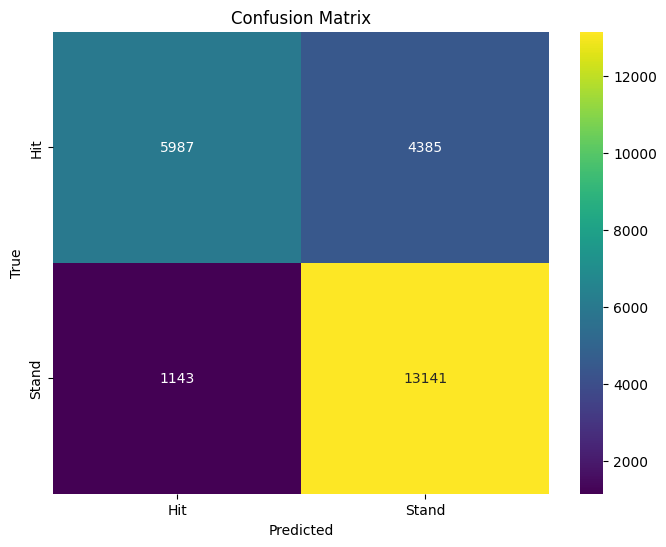

In [9]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Hit', 'Stand'], yticklabels=['Hit', 'Stand'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()




Model Interpretation:

The model's accuracy of 77.58% indicates its effectiveness in predicting the correct actions ('Hit' or 'Stand').

This suggests the KNN model's ability to capture the underlying patterns based on the features provided.
Recommended action: Stand
Probability of 'Hit': 0.32
Probability of 'Stand': 0.68


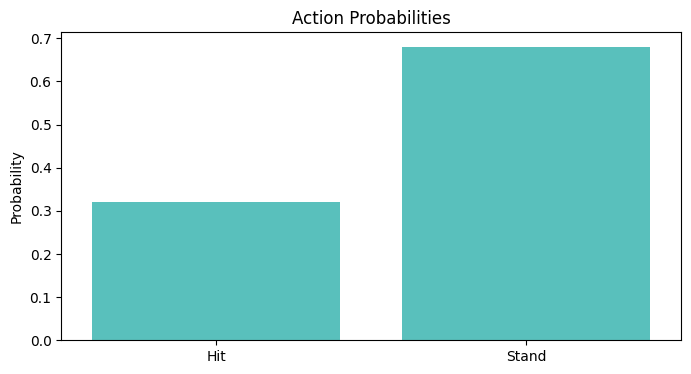

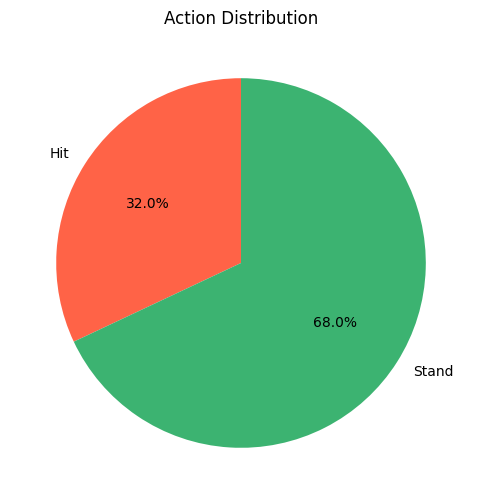

Recommended action: Stand
Probability of 'Hit': 0.08
Probability of 'Stand': 0.92


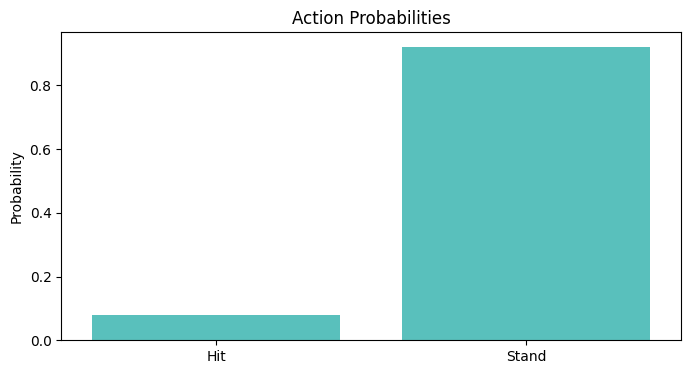

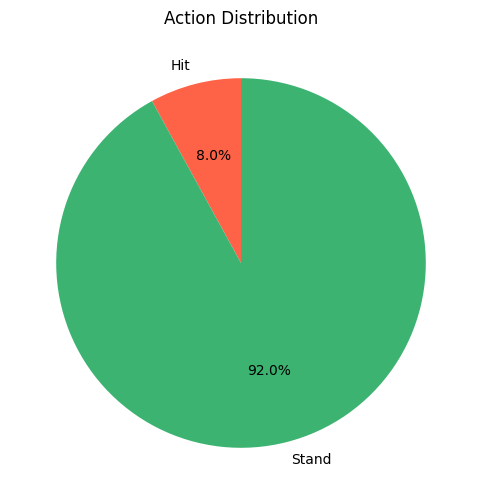

In [10]:
# Interpretation of the model's performance
print("Model Interpretation:\n")
print("The model's accuracy of {:.2f}% indicates its effectiveness in predicting the correct actions ('Hit' or 'Stand').".format(accuracy_score(y_test, y_pred) * 100))
print("\nThis suggests the KNN model's ability to capture the underlying patterns based on the features provided.")

# Example predictions
predict_action(10, 15, False, model)  # Example where dealer shows 10 and player has total 15 without an ace
predict_action(6, 12, True, model)    # Example where dealer shows 6 and player has total 12 with an ace




In [20]:
from tqdm import tqdm
import gym

env = gym.make("Blackjack-v1", sab=True)

n_episodes = 500_000  # play 500000 games

done = False
obs, info = env.reset(return_info=True)  # Handle reset with return_info=True

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
win, lose, even = 0, 0, 0

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset(return_info=True)  # Handle reset with return_info=True
    done = False

    # play one episode
    while not done:
        action = 0  # <- 0(stay) or 1(hit) using your model to give the action
        next_obs, reward, done, info = env.step(action)  # Corrected to unpack only 4 values

        # update if the environment is done and the current obs
        if done:
            if reward > 0:
                win += 1
            elif reward < 0:
                lose += 1
            else:
                even += 1
        obs = next_obs

total_game = win + lose + even

print("\nWin: {}\t({}%)\nLose: {}\t({}%)\nEven: {}\t({}%)\n".format(win, win/total_game*100, lose, lose/total_game*100, even, even/total_game*100))


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
  0%|          | 0/500000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 500000/500000 [00:57<00:00, 8632.95it/s]


Win: 192398	(38.479600000000005%)
Lose: 283418	(56.6836%)
Even: 24184	(4.8368%)

